In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np #
import pandas as pd 

from keras import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # This is added back by InteractiveShellApp.init_path()


In [2]:
labels = pd.read_csv('../input/dog-breed-identification/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


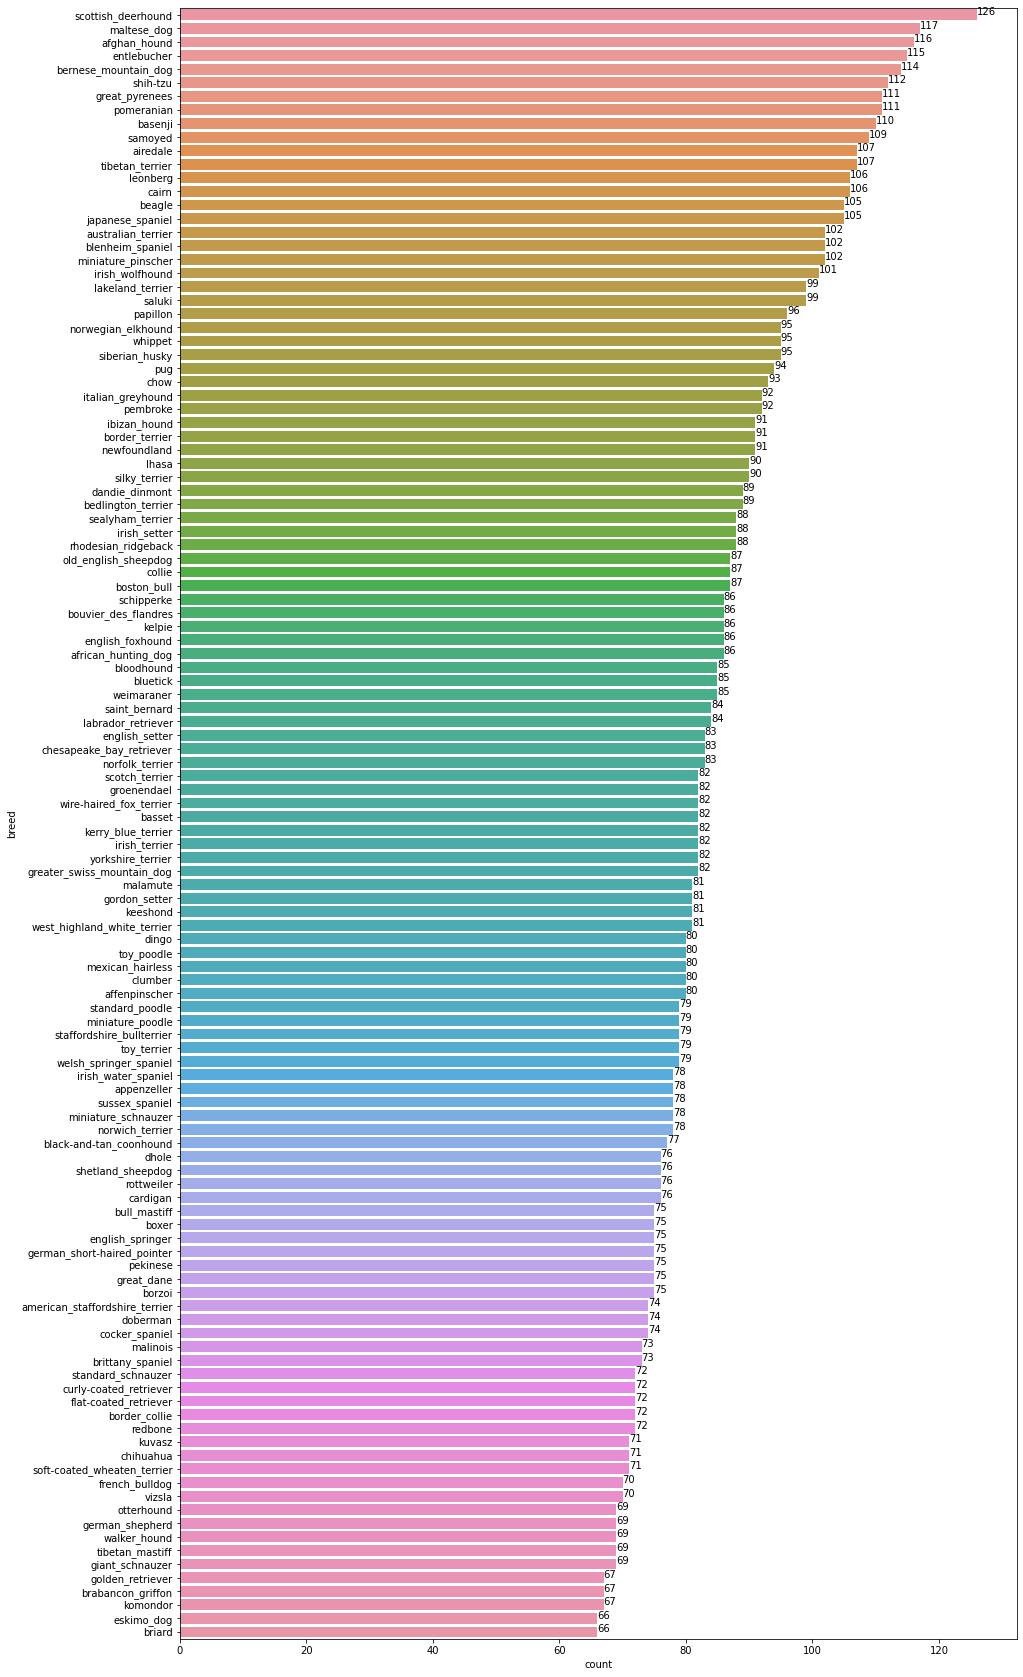

In [4]:
def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() 
        x = p.get_x()+ p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(round(val,2),(x,y))

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels['breed'],order=labels['breed'].value_counts().index)
barw(ax0)
plt.show()

In [5]:
import os
if len(os.listdir('../input/dog-breed-identification/train')) == len(labels['id']):
    print('equal images and labels')
else:
    print('number of images and labels are not equal')

equal images and labels


In [6]:
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total breeds {}'.format(n_classes))
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total breeds 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [7]:
input_shape = (331,331,3)


def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
        
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    y = to_categorical(y)
    
    return images,y

In [8]:
X,y = images_to_array('../input/dog-breed-identification/train', labels[:])

  0%|          | 0/10222 [00:00<?, ?it/s]

In [9]:
gc.collect()

83

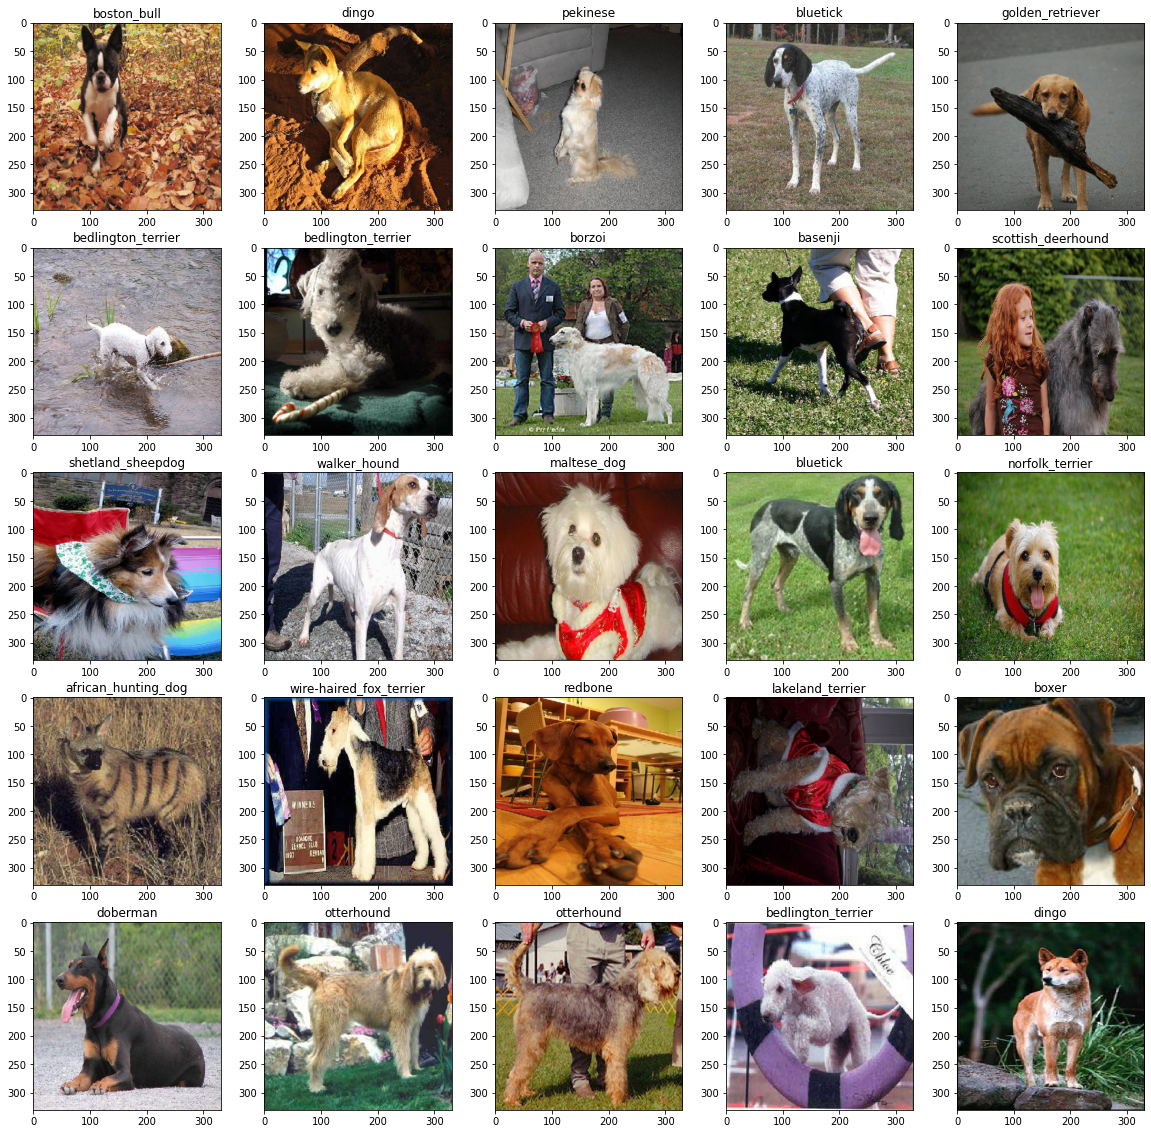

In [10]:
n=25

plt.figure(figsize=(20,20))

for i in range(n):
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32')) 

In [11]:
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [12]:
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [14]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

2022-04-28 07:14:06.457875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 07:14:06.583824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 07:14:06.584610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 07:14:06.585816: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


2022-04-28 07:14:11.627077: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3359797626 exceeds 10% of free system memory.
2022-04-28 07:14:14.944576: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3359797626 exceeds 10% of free system memory.
2022-04-28 07:14:17.486359: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-28 07:14:19.266156: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


320/320 [==============================] - 32s 79ms/step
Feature maps shape:  (10222, 2048)


In [15]:
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

83697664/83683744 [==============================] - 0s 0us/step


2022-04-28 07:14:52.235823: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3359797626 exceeds 10% of free system memory.
2022-04-28 07:14:55.851151: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3359797626 exceeds 10% of free system memory.


320/320 [==============================] - 48s 147ms/step
Feature maps shape:  (10222, 2048)


In [16]:
gc.collect()

64702

In [17]:
final_features = np.concatenate([inception_features,xception_features], axis=-1)
print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 4096)


In [18]:
model = Sequential()
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/50
64/64 [==============================] - 1s 7ms/step - loss: 2.0145 - accuracy: 0.6416 - val_loss: 0.4740 - val_accuracy: 0.9139
Epoch 2/50
64/64 [==============================] - 0s 4ms/step - loss: 0.3990 - accuracy: 0.9078 - val_loss: 0.3007 - val_accuracy: 0.9262
Epoch 3/50
64/64 [==============================] - 0s 4ms/step - loss: 0.2828 - accuracy: 0.9234 - val_loss: 0.2607 - val_accuracy: 0.9247
Epoch 4/50
64/64 [==============================] - 0s 4ms/step - loss: 0.2358 - accuracy: 0.9352 - val_loss: 0.2420 - val_accuracy: 0.9262
Epoch 5/50
64/64 [==============================] - 0s 4ms/step - loss: 0.1977 - accuracy: 0.9483 - val_loss: 0.2380 - val_accuracy: 0.9281
Epoch 6/50
64/64 [==============================] - 0s 4ms/step - loss: 0.1778 - accuracy: 0.9464 - val_loss: 0.2233 - val_accuracy: 0.9257
Epoch 7/50
64/64 [==============================] - 0s 4ms/step - loss: 0.1564 - accuracy: 0.9549 - val_loss: 0.2205 - val_accuracy: 0.9281
Epoch 8/50
64/64 [==

In [19]:
del inception_features
del xception_features
del final_features
gc.collect()

1659

In [22]:
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    gc.collect()
    final_features = np.concatenate([inception_features,xception_features],axis=-1)
    
    print('Final feature maps shape', final_features.shape)

    del inception_features
    del xception_features
    gc.collect()
    
    
    return final_features



In [23]:
#test_features = extact_features(test_data)

In [25]:
#del test_data
gc.collect()

23

In [26]:
from IPython.display import display
from PIL import Image

def predict_dog(link):
    basewidth = 300
    img = Image.open(link)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    display(img)
    img_g = load_img(link,target_size = img_size)
    img_g = np.expand_dims(img_g, axis=0)
    img_g.shape
    test_features = extact_features(img_g)
    predg = model.predict(test_features)
    print(f"Predicted label: {classes[np.argmax(predg[0])]}")
    print(f"Probability of prediction): {round(np.max(predg[0])) * 100} %")

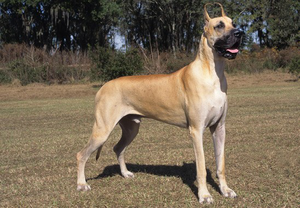

1/1 [==============================] - 1s 1s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 1s 687ms/step
Feature maps shape:  (1, 2048)
Final feature maps shape (1, 4096)
Predicted label: great_dane
Probability of prediction): 100 %


In [27]:
predict_dog("../input/custom-test/greatdane.jpg")

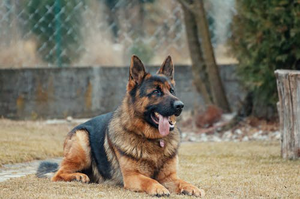

1/1 [==============================] - 1s 1s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 1s 670ms/step
Feature maps shape:  (1, 2048)
Final feature maps shape (1, 4096)
Predicted label: german_shepherd
Probability of prediction): 100 %


In [28]:
predict_dog('../input/custom-test/german_shepherd.jpeg')

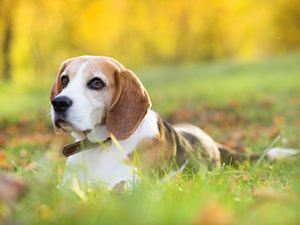

1/1 [==============================] - 1s 1s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 1s 611ms/step
Feature maps shape:  (1, 2048)
Final feature maps shape (1, 4096)
Predicted label: beagle
Probability of prediction): 100 %


In [29]:
predict_dog('../input/custom-test/unknown_dog1.jpg')

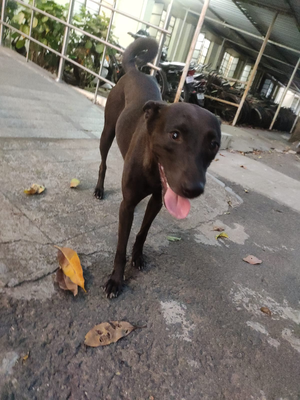

1/1 [==============================] - 1s 1s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 1s 608ms/step
Feature maps shape:  (1, 2048)
Final feature maps shape (1, 4096)
Predicted label: italian_greyhound
Probability of prediction): 0 %


In [33]:
predict_dog('../input/custom-test/vit_dog1.jpeg')

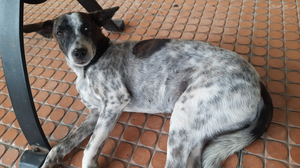

1/1 [==============================] - 1s 1s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 1s 600ms/step
Feature maps shape:  (1, 2048)
Final feature maps shape (1, 4096)
Predicted label: bluetick
Probability of prediction): 100 %


In [31]:
predict_dog('../input/custom-test/vit_dog2.jpeg')

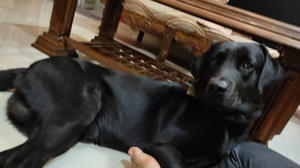

1/1 [==============================] - 1s 1s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 1s 594ms/step
Feature maps shape:  (1, 2048)
Final feature maps shape (1, 4096)
Predicted label: labrador_retriever
Probability of prediction): 100 %


In [34]:
predict_dog('../input/custom-test/house_dog1.jpeg')